In [1]:
import pickle
import rdkit
from rdkit import Chem
from rdkit.Chem import BondType
import re

필요한 함수 정의

In [2]:
def dgl_to_matrix(file_path):
    f = open(file_path, 'rb')
    dgls = pickle.load(f)

    smarts_list = list()
    smiles_errors = list()
    error_indices = []  # List to store the indices of molecules that caused an error

    for idx, g in enumerate(dgls):
        try:
            num_nodes = g.num_nodes()
            node_feature = g.ndata['feat']
            adj_matrix = g.edata['feat'].reshape(num_nodes, num_nodes)

            for i in range(adj_matrix.shape[0]):
                adj_matrix[i, i] = 0

            molecule = graph_to_molecule(node_feature, adj_matrix)

            smile = rdkit.Chem.MolToSmiles(molecule)
            sma = SmilesToSmarts(smile)
#           cano_smi = # canonicalize ### 은정님께 받으면 수정
            smarts_list.append(sma)
        except Exception as e:
            print(f"Error occurred at index {idx}: {e}")
            error_indices.append(idx)
            smiles_errors.append(smile)

    return smarts_list, smiles_errors, error_indices


In [3]:
bond_mapping = {"SINGLE": 1, "DOUBLE": 2, "TRIPLE": 3, "AROMATIC": 4}
bond_mapping.update({1:BondType.SINGLE, 2: BondType.DOUBLE, 3: BondType.TRIPLE, 4: BondType.AROMATIC})
print('bond_mapping: ', bond_mapping)

SMILE_CHARSET = ['C', 'F', 'H', 'N', 'O']
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print('atom_mapping: ', atom_mapping)

bond_mapping:  {'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3, 'AROMATIC': 4, 1: rdkit.Chem.rdchem.BondType.SINGLE, 2: rdkit.Chem.rdchem.BondType.DOUBLE, 3: rdkit.Chem.rdchem.BondType.TRIPLE, 4: rdkit.Chem.rdchem.BondType.AROMATIC}
atom_mapping:  {'C': 0, 'F': 1, 'H': 2, 'N': 3, 'O': 4, 0: 'C', 1: 'F', 2: 'H', 3: 'N', 4: 'O'}


In [4]:
def graph_to_molecule(features, adjacency):
    molecule = Chem.RWMol()  # 편집 가능한 빈 molecule 추가
    num_atoms = len(features)
    atom_index_map = {}

    # 'features' 이용해서 molecule에 atom 추가
    for i in range(num_atoms):
        atom_type = features[i].item() # Convert tensor to int
        atom_symbol = atom_mapping[atom_type]
        new_atom_index = molecule.AddAtom(Chem.Atom(atom_symbol))
        atom_index_map[i] = new_atom_index

    # 'adjacency' 이용해서 molecule에 bond 추가
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            bond_type_idx = adjacency[i, j].item()  # Convert tensor to int

            if bond_type_idx == 0:
                continue

            bond_type = bond_mapping[bond_type_idx]

            new_i = atom_index_map[i]
            new_j = atom_index_map[j]

            if bond_type != 0:
                molecule.AddBond(new_i, new_j, bond_type)

    return molecule

In [5]:
def molWatom(mol):  # smiles 에 smarts 처럼 위치정보를 입력하는 함수
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def SmilesToSmarts(smi):
    mol = Chem.MolFromSmiles(smi)
    mol_w_atom = molWatom(mol)
    sma = Chem.MolToSmarts(mol_w_atom)

    smia = mol_w_atom.GetAtoms()
    smial = [i.GetSymbol() for i in smia]

    t1 = re.compile('#\d+')
    result = t1.findall(sma)

    for i, j in enumerate(result):
        sma = sma.replace(j, smial[i], 1)

    return sma

In [18]:
def save_smarts_to_txt(smarts_list, file_path):
    with open(file_path, 'w') as f:
        for sma in smarts_list:
            f.write(sma + '\n')

In [6]:
file_path = './extracted_fmo_data.pkl'
smarts_list, smiles_errors, error_indices = dgl_to_matrix(file_path)

[18:23:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 5 6 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[18:23:56] Can't kek

Error occurred at index 18: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 31: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 52: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 54: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 82: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 87: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 99: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 117: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 126: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 136: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 207: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 227: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 228: 'NoneType' object has no attribute 'GetAtoms'
Error occurred at index 239: 'No

[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 6 7 8
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:23:56] Can't kekulize mol.  Unkekulized atoms: 2 3 4
[18:23:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7
[18:23:57] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 8


In [19]:
file_path = './smarts_list_670.txt'
save_smarts_to_txt(smarts_list, file_path)

In [7]:
smiles_errors

['NC(=O)c1ccnn1',
 'N=c1cc(O)cc(N)n1',
 'N#Cc1nc(O)nc1N',
 'OCc1nnnc1O',
 'CC(=NO)c1cccn1',
 'COCc1cnc(C)n1',
 'N=c1cnnc(CO)c1',
 'N=c1nnc(N)c(N)n1',
 'CCCNc1ncnn1',
 'CCOc1nnnc1O',
 'O=Cc1ccnc1CO',
 'Cc1cncc(F)c1=N',
 'Nc1nc2ncnc2o1',
 'C1=Cc2nccc2NC1',
 'CC1COc2cnnc21',
 'N=c1ncncn1',
 'CC1(c2cnnn2)CC1',
 'CNc1nnc(C#N)n1',
 'CC(O)c1cnnn1',
 'CC(=O)Cc1ncnn1',
 'N#Cc1nnnc1N',
 'COc1cnc(=N)cn1',
 'N=c1nc(=O)onc1O',
 'Cc1ccc(=O)nc1O',
 'CC#Cc1ncnc1C',
 'Nc1ncnc(=O)n1',
 'Cc1nc(F)cc(=N)n1',
 'O=c1nncnc1CO',
 'N=c1nc(O)ccc1F',
 'NC(=O)c1coc(=O)n1',
 'Cc1ncnc1CCO',
 'Cc1ncc(CC#N)n1',
 'Cn1nnnc1=N',
 'C#CCCc1cccn1',
 'C#CC(N)c1nccn1',
 'O=C1Cc2cnnc2N1',
 'CCC(C)c1cnnn1',
 'c1nc2ncoc2n1',
 'N=c1nnnc(=O)n1',
 'N=c1cnc(=N)nnn1',
 'Cc1cncnc1=O',
 'N=c1ncc(C2CN2)o1',
 'N=c1ccnc(O)c1F',
 'CN=c1cc(N)cnn1']

In [8]:
len(smiles_errors)

44

In [9]:
len(error_indices)

44

In [10]:
len(smarts_list)

670

In [11]:
smiles_errors[2]

'N#Cc1nc(O)nc1N'

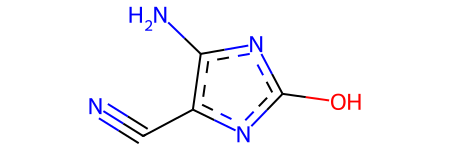

In [12]:
mol_without_kekulization = rdkit.Chem.MolFromSmiles(smiles_errors[2], sanitize=False)
mol_without_kekulization


In [13]:
 # Convert the non-kekulized molecule to SMILES
smiles_without_kekulization = rdkit.Chem.MolToSmiles(mol_without_kekulization)
print('smiles_without_kekulization: ', smiles_without_kekulization)

smiles_without_kekulization:  N#Cc1nc(O)nc1N


In [14]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

[18:24:14] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


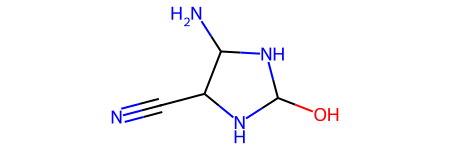

In [15]:
mol = molecule_from_smiles(smiles_errors[2])
mol

In [16]:
sma_mol = [Chem.MolFromSmarts(i) for i in smarts_list]
len(sma_mol)

670

In [20]:
sma_mol_20 = sma_mol[20:40]
sma_mol_20

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(sma_mol_20, molsPerRow=4)